# [Modeling] Spatial Contexts for Los Angeles

In [473]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline
plt.style.use('fivethirtyeight')

## Predictive Modeling

Here we will use of CalEPA data for Los Angeles to draw inference and predictions using various models, including unsupervised and supervised models.

In [474]:
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0).dropna()
ces_la["CES 4.0 Percentile Range"] = ces_la['CES 4.0 Percentile Range'].replace("1-5% (lowest scores)", "00-05%").replace("5-10%", "05-10%").replace("95-100% (highest scores)", "95-100%")

In [475]:
ces_la

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,CES 4.0 Percentile,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100%,0.048,...,99.97,13.34,72.59,14.07,97.27,1.71,0.84,0.00,0.00,0.18
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100%,0.042,...,99.91,18.60,72.48,8.92,78.14,1.09,15.67,0.00,4.84,0.25
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100%,0.049,...,99.87,7.70,84.50,7.80,75.55,2.85,10.45,0.00,6.95,4.20
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100%,0.041,...,99.86,12.77,73.16,14.07,69.34,3.98,8.43,0.00,16.32,1.92
5,6037433501,1949,Los Angeles,91733,South El Monte,-118.065122,34.057255,76.91,95-100%,0.055,...,99.85,10.98,75.42,13.60,93.89,0.72,0.00,0.00,5.39,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,6037262604,5523,Los Angeles,90272,Los Angeles,-118.548578,34.051108,3.85,00-05%,0.051,...,1.31,14.01,58.34,27.65,3.31,86.24,0.00,0.00,5.63,4.82
2056,6037670702,5649,Los Angeles,90275,Rancho Palos Verdes,-118.328443,33.753600,3.53,00-05%,0.039,...,1.02,7.97,65.59,26.45,8.43,68.53,1.12,0.42,15.29,6.21
2057,6037620904,2897,Los Angeles,90266,Manhattan Beach,-118.410369,33.880731,3.08,00-05%,0.043,...,0.72,12.60,70.80,16.60,4.42,85.71,0.00,0.00,2.35,7.53
2058,6037262802,3424,Los Angeles,90272,Los Angeles,-118.502456,34.045865,2.23,00-05%,0.050,...,0.34,11.42,61.89,26.69,10.72,80.96,0.32,0.00,2.98,5.02


In [476]:
identifiers = ['Census Tract', 'Total Population', 'California County', 'ZIP', 'Approximate Location', 'Longitude', 'Latitude', 'CES 4.0 Score', 'CES 4.0 Percentile Range', 'CES 4.0 Percentile']
pctl = list(ces_la.filter(regex = 'Pctl'))

One important detail before moving forward: the CES 4.0 Percentile Ranges are updated from 5% increments to 10% increments to better align with the work of the CalEPA CalEnviroScreen 4.0. 

In [477]:
temp_range = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
new_range = np.array(['00-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

In [478]:
ranges = ces_la['CES 4.0 Percentile Range'].to_numpy()

for i in np.arange(len(ranges)):
    index = len(int(ranges[i][:2]) < temp_range) - sum(int(ranges[i][:2]) < temp_range)
    ranges[i] = new_range[index]

In [479]:
ces_la['CES 4.0 Percentile Range'] = ranges

## 1. Unsupervised Modeling

Without telling our models about the CES 4.0 Scores nor corresponding Percentile groups, can they learn about them? 

Can we use specific features to predict a score, population characteristic, or pollution indicator?

## A. Principal Component Analysis

Why PCA? We are:

1. Visually identifying clusters of similar observations in high dimensions.
2. We have reason to believe that the data are inherently low rank: there are many attributes, but only a few  attributes mostly determine the rest through a linear association.

Are there features we should be aware of that guide our understanding of the CES 4.0 Scores?


In [480]:
from sklearn.decomposition import PCA

In [481]:
def pca_fit_df(df):
    """Performs PCA fit transform for the given DataFrame and assigns original CES 4.0 Percentile Range"""
    
    pca_vals = PCA(n_components=2).fit_transform(df)
    pca_tbl = pd.DataFrame(pca_vals, columns=['x','y'])
    pca_tbl['CES 4.0 Percentile Range'] = ces_la['CES 4.0 Percentile Range'].to_numpy()
    
    return pca_tbl

In [482]:
def pca_visualization(pca_df, indicator_str):
    """Plots PCA using PCA Dataframe from func: pca_df"""
    
    rcParams['figure.figsize'] = 8,8

    sns.scatterplot(data=pca_df, x='x', y='y', hue='CES 4.0 Percentile Range', palette=sns.color_palette("RdYlGn", 10))
    plt.title('PCA by CES 4.0 Percentile Range using ' + indicator_str)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [483]:
# Remove identifiers and perentiles

df_pca = ces_la.drop(columns=identifiers).drop(columns=pctl)
df_cols = list(df_pca.columns)

In [484]:
# Standardize data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)
df_pca = pd.DataFrame(df_scaled)
df_pca = df_pca.set_axis(df_cols, axis=1)

### PCA using Population Characteristics and Pollution Burden

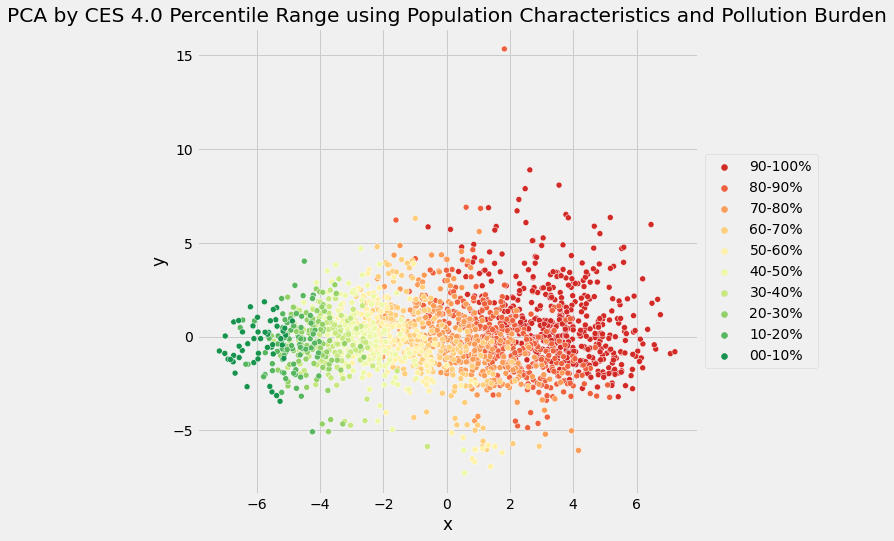

In [485]:
pca_all = pca_fit_df(df_pca)

pca_visualization(pca_all, 'Population Characteristics and Pollution Burden')

From this, we learn that our data does inheriently cluster in a 2D space for each of the CES 4.0 Percentile Ranges.

How much information do we lose? There are different ways to determine it. One of such was is a Scree Plot, but it is met with criticism based on the form of standardization performed [(source)](https://en.wikipedia.org/wiki/Scree_plot).

### PCA using Population Characteristics 

Next, is it possible to get similar results just using population characteristic data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [486]:
sensitive = ['Asthma', 'Low Birth Weight', 'Cardiovascular Disease', 'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden']
socioeconomic = ['Children < 10 years (%)', 'Pop 10-64 years (%)', 'Elderly > 64 years (%)', 'Hispanic (%)', 'White (%)', 'African American (%)', 'Native American (%)', 'Asian American (%)', 'Other/Multiple (%)']

In [487]:
# Population Characteristics

df_population = df_pca[sensitive + socioeconomic]

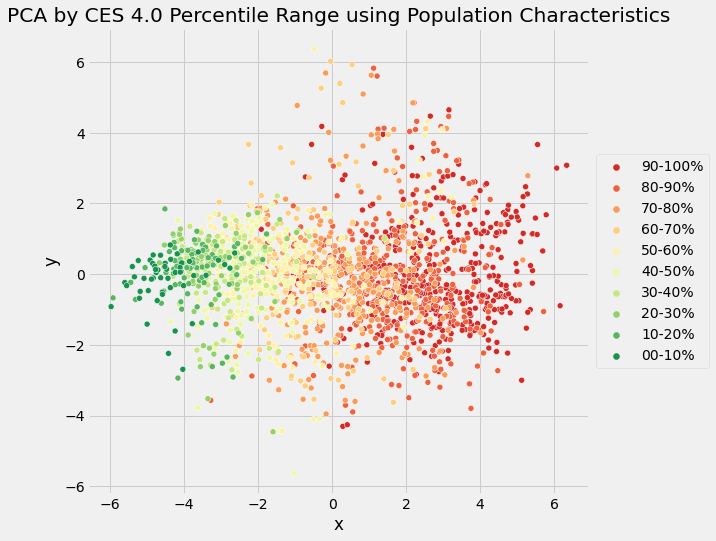

In [488]:
pca_population = pca_fit_df(df_population)

pca_visualization(pca_population, 'Population Characteristics')

Yes! It seems like PCA is able to achieve similar results just using population characteristics.

#### Breakdown of Population Charactierstics

In [489]:
# Sensitive Indicators

df_population_sens = df_pca[sensitive]

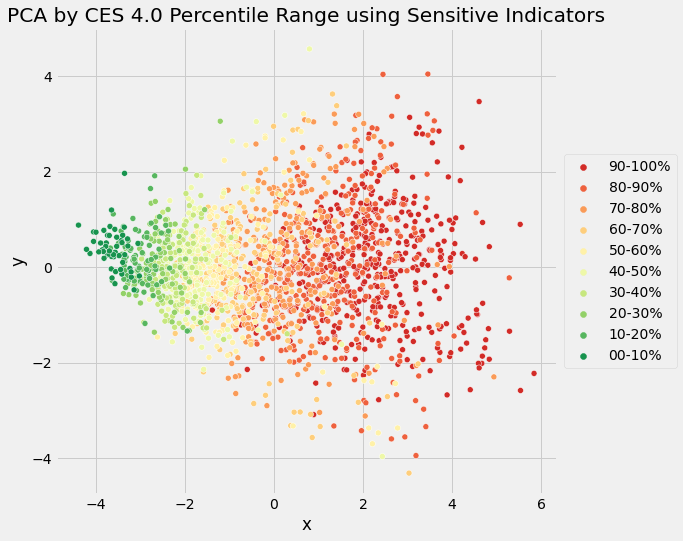

In [490]:
pca_population_sens = pca_fit_df(df_population_sens)

pca_visualization(pca_population_sens, 'Sensitive Indicators')

In [491]:
# Socioeconomic Indicators

df_population_se = df_pca[socioeconomic]

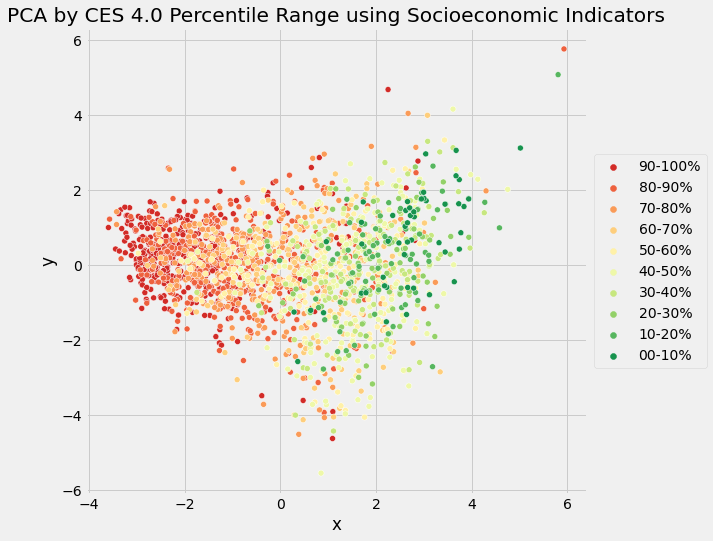

In [492]:
pca_population_se = pca_fit_df(df_population_se)

pca_visualization(pca_population_se, 'Socioeconomic Indicators')

### PCA using Pollution Burden

Next, is it possible to get similar results just using pollution burden data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [493]:
exposures = ['Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Lead', 'Pesticides', 'Tox. Release', 'Traffic']
effects = ['Cleanup Sites', 'Groundwater Threats', 'Haz. Waste', 'Imp. Water Bodies', 'Solid Waste']

In [494]:
# Pollution Burden

df_pollution = df_pca[exposures + effects]

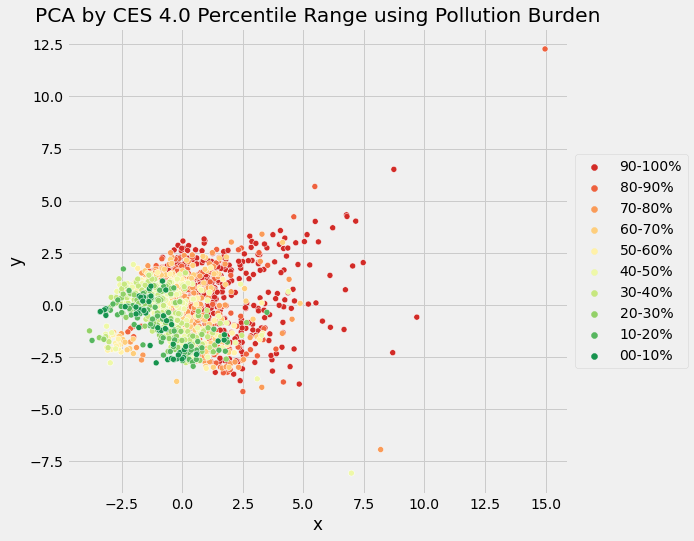

In [495]:
pca_pollution = pca_fit_df(df_pollution)

pca_visualization(pca_pollution, 'Pollution Burden')

Initially, we see PCA performs really differently between Population Characteristics and Pollution Burden. This may be influenced by the outliers, despite working with standardized data.

#### Breakdown of Pollution Burden

One important consideration from the CalEPA CalEnviroScreen 4.0 is that pollution burden and population characteristics are broken down: exposures and effects, as well as sensitive factors and socioeconomic factors. In fact, in calculating the scores, environmental effects are weighted half as much as exposures. Is a PCA model able to identify these distinctions?

In [496]:
# Exposure Indicators

df_pollution_exp = df_pca[exposures]

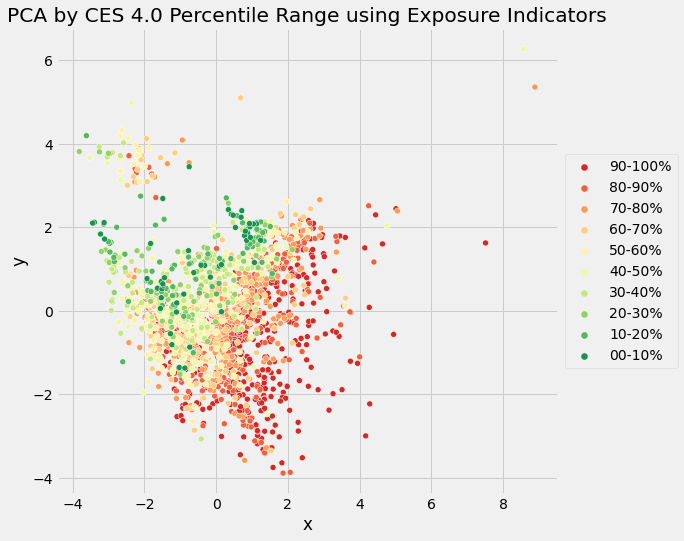

In [497]:
pca_pollution_exp = pca_fit_df(df_pollution_exp)

pca_visualization(pca_pollution_exp, 'Exposure Indicators')

In [498]:
# Effect Indicators

df_pollution_eff = df_pca[effects]

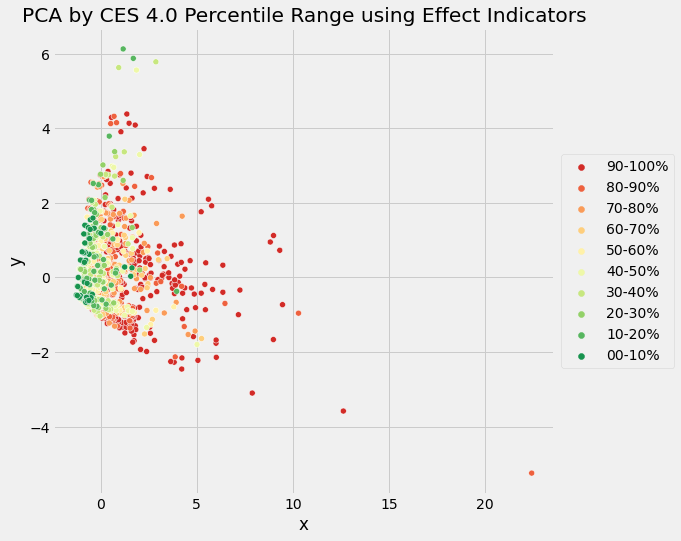

In [499]:
pca_pollution_eff = pca_fit_df(df_pollution_eff)

pca_visualization(pca_pollution_eff, 'Effect Indicators')

## B. Clustering

In [500]:
from sklearn.cluster import SpectralClustering

In [501]:
pca_pop_x_y = pca_all.copy()

In [502]:
clustering = SpectralClustering(n_clusters=10, assign_labels='discretize', random_state=1).fit_predict(pca_pop_x_y.iloc[:, :2])

In [503]:
pca_pop_x_y['Cluster'] = clustering + 1
pca_pop_x_y = pca_pop_x_y.sort_values("Cluster", ascending=True)
pca_pop_x_y['Cluster'] = pca_pop_x_y['Cluster'].apply(str)

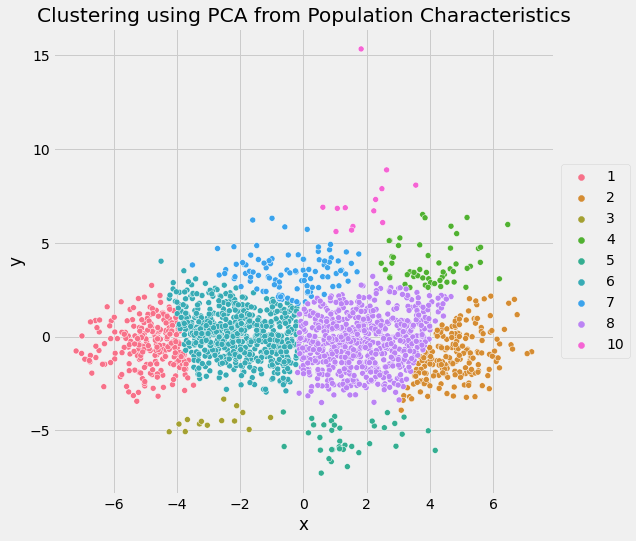

In [504]:
# Visualization

rcParams['figure.figsize'] = 8,8

sns.scatterplot(data=pca_pop_x_y, x='x', y='y', hue='Cluster')
plt.title('Clustering using PCA from Population Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Clustering via SpectralClustering is able to identify 20 different clusters, but it is not as well-defined as what we see with PCA.

## 2. Supervised Modeling

Techniques such as PCA help us in finding relationships across our data to reduce its dimensionality while still giving us an effective representation of all of the data. Now, how well can we predict the CES 4.0 Percentile Range of a data point using our PCA-created data? How might predictions turn out for all data, population characteristics, and pollution burden?

An important question is what might be the use case for classification? As communities change, are there examples in which we can predict a possible changes to its landscape, as determined by CES 4.0 Scores? Given our limited data, we can't make predictions over time, but this would be able to give us an idea. This is a limitation that we can draw some understanding from.

## A. Classification

Given our spatial data created from PCA, we will use k-Nearest Neighbors classification.

However, given the large amount of classes, we will aggregate them to 10% increments to preserve as much detail as possible.

In [505]:
from sklearn.neighbors import KNeighborsClassifier

In [506]:
def k_neighbors(df):
    """Returns a DataFrame with data and predictions."""
    
    X = df.drop(columns=['CES 4.0 Percentile Range'])
    y = df['CES 4.0 Percentile Range']
    
    min_k = 3
    max_k = 15
    
    records = {}
    
    for k in np.arange(min_k, max_k+1, 2):
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

        neighbors_all = KNeighborsClassifier(n_neighbors=k)
        neighbors_all.fit(X_train, y_train)

        y_pred = neighbors_all.predict(X_test)
        
        records[k] = accuracy_score(y_test, y_pred)
        
        rcParams['figure.figsize'] = 6,4
        plt.plot(records.keys(), records.values())
        plt.title("KNN K-Values and Accuracy")
        plt.xlabel("K-Values")
        plt.ylabel("Accuracy")
    
    return max(records, key=records.get)

### Classification using Population Characteristics and Pollution Burden

In [507]:
knn_df = pca_fit_df(df_pca)

15

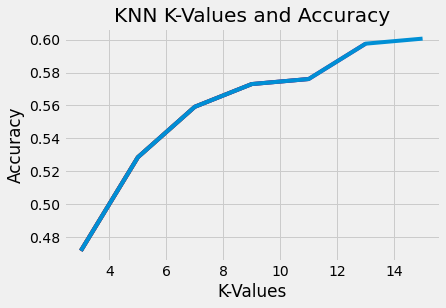

In [508]:
k_neighbors(knn_df)

In [509]:
X = pca_fit_df(df_pca).iloc[:, :2]
y = pca_fit_df(df_pca).iloc[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [510]:
neighbors_all = KNeighborsClassifier(n_neighbors=25)
neighbors_all.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [511]:
y_pred = neighbors_all.predict(X_test)

In [512]:
# Accuracy

print(accuracy_score(y_test, y_pred))

0.5806451612903226


In [513]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      00-10%       0.71      0.67      0.69        15
      10-20%       0.27      0.41      0.33        17
      20-30%       0.29      0.17      0.21        30
      30-40%       0.34      0.40      0.37        35
      40-50%       0.57      0.58      0.57        67
      50-60%       0.38      0.41      0.40        58
      60-70%       0.47      0.41      0.44        79
      70-80%       0.59      0.67      0.63        93
      80-90%       0.59      0.61      0.60       107
     90-100%       0.88      0.80      0.84       150

    accuracy                           0.58       651
   macro avg       0.51      0.51      0.51       651
weighted avg       0.59      0.58      0.58       651



### Classification using Population Characteristics

In [514]:
k_neighbors(df_population)

KeyError: "['CES 4.0 Percentile Range'] not found in axis"

### Classification using Pollution Burden

In [ ]:
k_neighbors(df_pollution)